# How to run a `JAGS` model in Jupyter Notebook without `pyjags`

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

You need to install `JAGS` from official SourceForge https://sourceforge.net/projects/mcmc-jags/

***

Generate random data

In [2]:
N = 25

In [3]:
np.random.seed(42)
x = np.linspace(0, 10, N) + (np.random.random(N)-.5) * 10

In [4]:
np.random.seed(0)
y = x*3 + (np.random.random(N)-.5) * 10

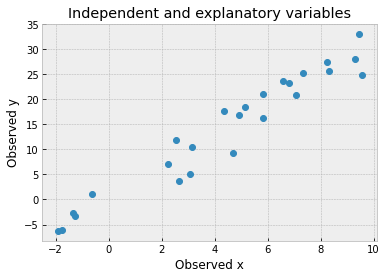

In [5]:
with plt.style.context("bmh"):
    plt.plot(x, y, 'o')
    plt.xlabel("Observed x")
    plt.ylabel("Observed y")
    plt.title("Independent and explanatory variables")

***

Define a simple linear regression model and save it to a file

In [6]:
# the Model Code
model_code = """
model{
    for(i in 1:N){
        Y[i] ~ dnorm(alpha + beta * x[i], tau)
    }
    alpha ~ dnorm(0.0, 1.0E-4)
    beta ~ dnorm(0.0, 1.0E-4)
    sigma <- 1.0/sqrt(tau)
    tau ~ dgamma(1.0E-3, 1.0E-3)
}
"""

In [7]:
# write Model Code
with open("model_code.bug", "w") as f:
    f.write(model_code)

***

Write in a file observed data in `R` style 

In [8]:
# Model Data to R style
string = """"x" <- c("""
string += ", ".join(x.astype(str))
string += ")\n"
string += """"Y" <- c("""
string += ", ".join(y.astype(str))
string += ")\n"
string += """"N" <- """
string += str(x.size)
print(string)

"x" <- c(-1.254598811526375, 4.923809730765829, 3.153272751447384, 2.236584841970366, -1.7731469289089683, -1.3567214633046398, -1.9191638783180052, 6.5784281244160185, 4.344483450765422, 5.830725777960454, -0.6274883903753086, 9.282431854953277, 8.324426408004218, 2.5400577734494285, 2.65158300540434, 3.084045098534338, 4.709089096262044, 7.3308976496557126, 6.819450186421157, 5.828958068647086, 9.451862280557128, 5.144938606520419, 7.088113152018849, 8.24695176627025, 9.56069984217036)
"Y" <- c(-3.2756613953058777, 16.92332285602168, 10.487452015058592, 7.158586355880066, -6.082892793337858, -2.6112232592473585, -6.381619522327091, 23.653014381068854, 17.67007795730656, 16.32659252213914, 1.0347852097007202, 28.136244762388877, 25.653724834951976, 11.876139703274896, 3.665109598191889, 5.1234282926184225, 9.32945126318939, 25.318891404446518, 23.239918068761977, 21.18699568840945, 33.14177026399902, 18.426401461728492, 20.879133078585866, 27.546147061675306, 24.864843785200414)
"N" <

In [9]:
# write Model Data
with open("model_data.R", "w") as f:
    f.write(string)

***

Write in a file parameters inits in `R` style

In [10]:
# Data init to R style
string_init = """"alpha" <- 0\n"""
string_init += """"beta" <- 1\n"""
string_init += """"tau" <- NA"""
print(string_init)

"alpha" <- 0
"beta" <- 1
"tau" <- NA


In [11]:
# write Model Inits
with open("model_init.R", "w") as f:
    f.write(string_init)

***

Define chains, update and iterations per chain. Then, write the commands to be executed (see `JAGS` documentation for details)

In [12]:
chains = 2
update = 1000
iter_per_chain = 5000

# Model commands
model_cmd = f"""
model in "model_code.bug"
data in "model_data.R"
compile, nchains({chains})
inits in "model_init.R"
initialize
update {update}
monitor alpha
monitor beta
update {iter_per_chain}
coda *
exit
"""

In [13]:
# write Model Inits
with open("model.cmd", "w") as f:
    f.write(model_cmd)

***

Run the model in bash

In [14]:
%%bash
jags model.cmd

Welcome to JAGS 4.3.0 on Mon Nov 15 11:08:30 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
Reading data file model_data.R
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25
   Unobserved stochastic nodes: 3
   Total graph size: 110
Reading initial values file model_init.R
Initializing model
Updating 1000
Updating 5000


***

Open and read the _CODAindex.txt_ generated file to know indexes of monitored parameters

In [15]:
with open("CODAindex.txt", "r") as f:
    coda_index = f.read().splitlines()

In [16]:
# Read var names and start-end indexes in Coda chain files
n_vars = 0
var_index = {}
for variables in coda_index:
    n_vars += 1
    split = variables.split(" ")
    var_name = split[0]
    var_start = split[1]
    var_end = split[2]
    var_index.update({var_name: {"start": int(var_start), "end": int(var_end)}})

In [17]:
var_index

{'alpha': {'start': 1, 'end': 5000}, 'beta': {'start': 5001, 'end': 10000}}

***

Read the _CODAchain{chain}.txt_ generated files and load parameters samples and put them in a dictionary
```
{
    "var_name": np.zeros( shape=(dim, iterations per chain, chains) ),
    ...
}
```

In [18]:
coda = {}

for var_name in var_index:
    print(f"Loading `{var_name}` samples...")
    coda.update({var_name: np.zeros(shape=(1, iter_per_chain, chains))})
    for chain in np.arange(chains):
        with open(f"CODAchain{chain+1}.txt", "r") as f:
            samps = f.read().splitlines()
            for i, samp in enumerate(samps[var_index[var_name]["start"]-1: var_index[var_name]["end"]]):
                var_sample = samp.split("  ")[1]
                coda[var_name][0,i,chain] = float(var_sample)

Loading `alpha` samples...
Loading `beta` samples...


***

Load samples in arviz

In [19]:
az_data = az.from_pyjags(coda)

Print the summary (see `arviz` documentation for details)

In [20]:
smry = az.summary(az_data)
smry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.457,0.979,-1.342,2.356,0.019,0.014,2542.0,4521.0,1.0
beta,3.103,0.174,2.786,3.446,0.003,0.002,2546.0,4339.0,1.0


***

Plot posteriors (see `arviz` documentation for details)

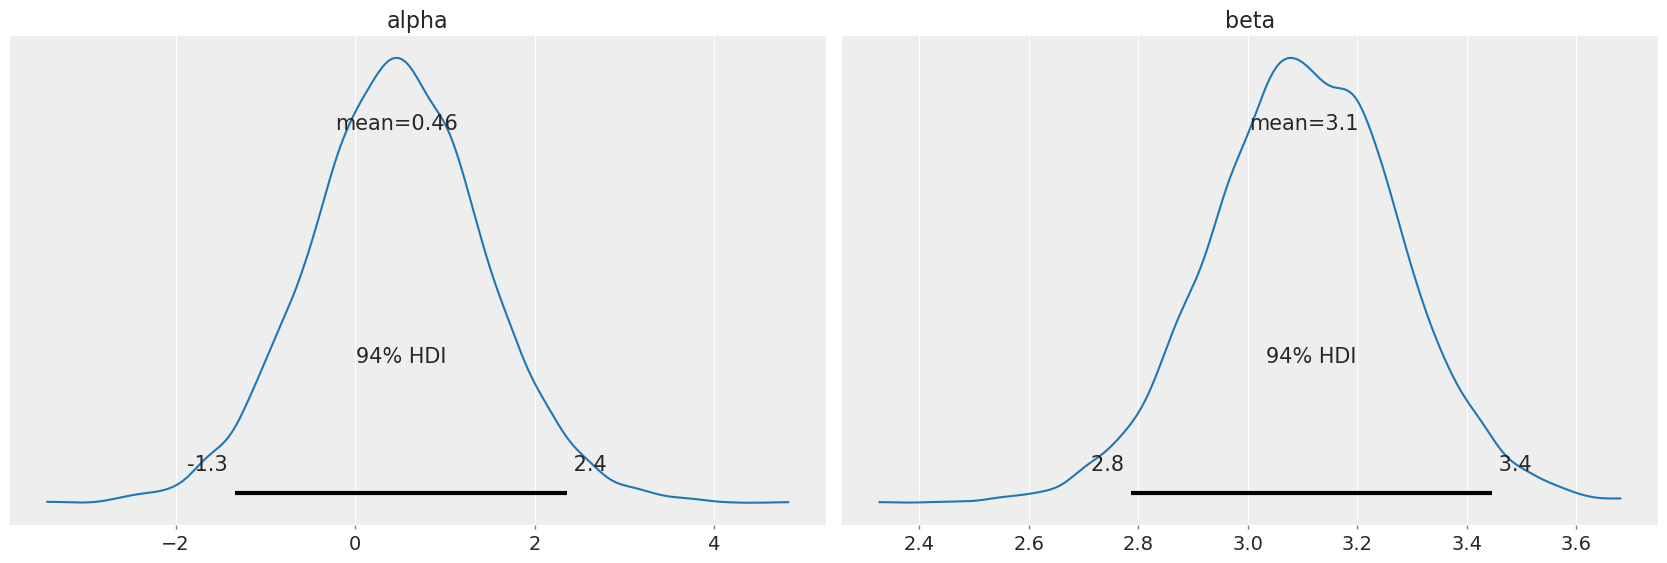

In [21]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_posterior(az_data);

Print traces (see `arviz` documentation for details)

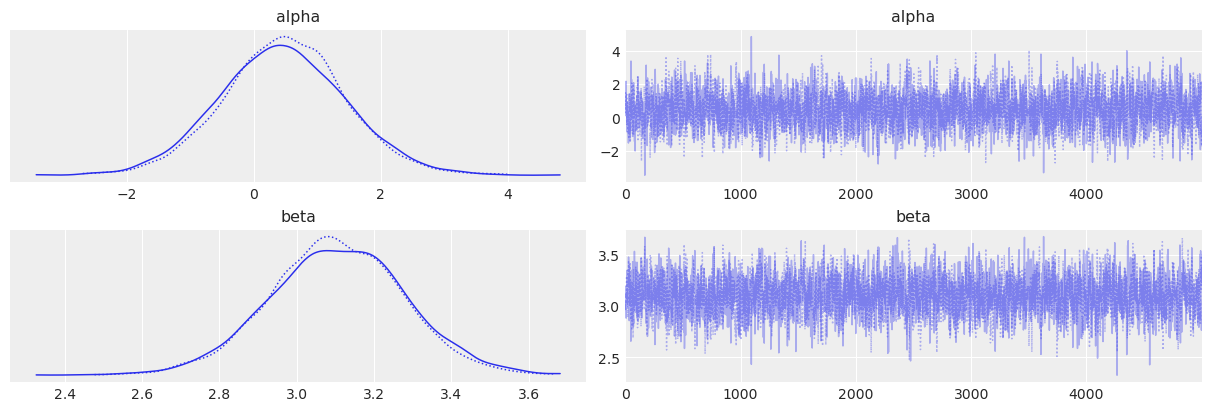

In [22]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(az_data, var_names=("alpha", "beta"));

Plot mean and chosen HDI of monitored parameters

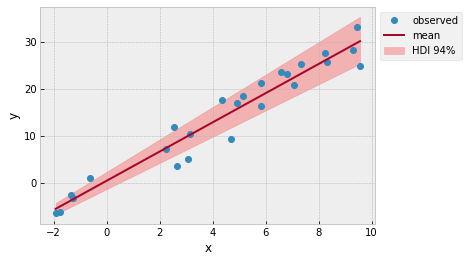

In [23]:
with plt.style.context("bmh"):
    _x = np.linspace(x.min(), x.max())
    _y = az_data.posterior.alpha.median().values + az_data.posterior.beta.median().values * _x
    plt.plot(x, y, 'o', label="observed")
    plt.plot(_x, _y, label="mean")
    a = smry.loc["alpha", "hdi_3%"]
    b = smry.loc["beta", "hdi_3%"]
    lo = a + b*_x
    a = smry.loc["alpha", "hdi_97%"]
    b = smry.loc["beta", "hdi_97%"]
    hi = a + b*_x
    plt.fill_between(_x, lo, hi , alpha=.25, color='r', label="HDI 94%")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))